# Visualization, Fitting, and File Format

This is a warm-up notebook to demonstrate some python APIs we will use frequently during our workshop.

<img src="logos/applogo.png" style="width: 80%;">


With knowledge about Python basics and numpy array, you can massage and play with data. What comes next immediately includes how to _visualize_ data, _fit_ a function (=test against a model), explore more with an _interactive (dynamic)_ visualization, and a _file format_ for more flexible/efficient storage beyond numpy file.

We cover additional libraries briefly to address those basic needs.

* [`matplotlib` for static plots and figures](#mpl)
* [`scipy` for fitting a function](#scipy)
* [`plotly` for an interactive (dynamic) plotting](#plotly)
* [`hdf5`: an alternative data file format](#hdf5)

This notebook is based on [tutorial](https://github.com/marcodeltutto/Python-Tutorial-SBN-Workshop) by Marco Del Tutto for an introductory workshop.


In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a href="mpl"></a>
## Matplotlib for static visualization
`matplotlib` is one of the most used scientific python packages for data visualization. You can create a scatter plot, histogram, errorbar, surface, ... a lot! We will try visualizing an image file first using one of the most familiar figures in the United States.

<img src="logos/matplotlib.png" style="width: 250px;">


We will use a `Homer.png` image file.

In [2]:
data=plt.imread('data/Homer.png')
print('Data shape:',data.shape)
print('Data type:',type(data))

Data shape: (500, 300, 4)
Data type: <class 'numpy.ndarray'>


So this image has 4 [CMYK channels](https://en.wikipedia.org/wiki/Channel_(digital_image)#CMYK). Let's visualize the image using `matplotlib.pyplot.imshow`

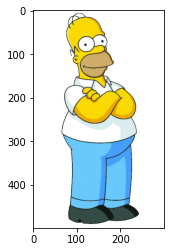

In [3]:
plt.imshow(data)
plt.show()

Next, make a canvas with (1,N) sub-plots, where we will draw a gray-scale image for each image channel by slicing one by one.

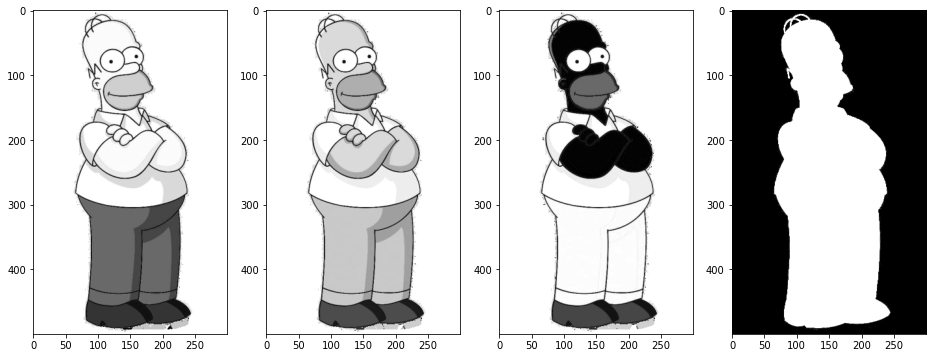

In [4]:
fig,axes=plt.subplots(1,data.shape[2],figsize=(16,8),facecolor='w')
for ch in range(data.shape[2]):
    axes[ch].imshow(data[:,:,ch],cmap='gray')
plt.show()

If you miss `ROOT` and in particular a _typical HEP color scale_ (i.e. dark blue, cyan, green, yellow, dark red respecitvely for increasing intensity), probably the easiest is to use `cmap='jet'`.

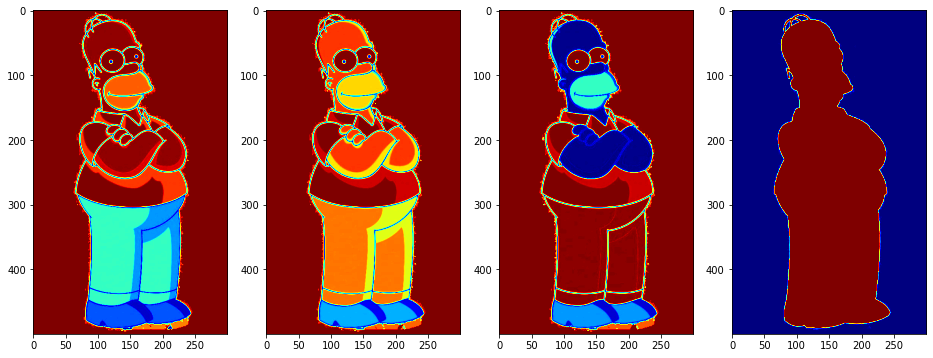

In [5]:
fig,axes=plt.subplots(1,data.shape[2],figsize=(16,8),facecolor='w')
for ch in range(data.shape[2]):
    axes[ch].imshow(data[:,:,ch],cmap='jet')
plt.show()

But what are the pixel values (pretend you don't know the answer please)? Let's slice then reshape into 1D array, and histogram pixel values per channel.

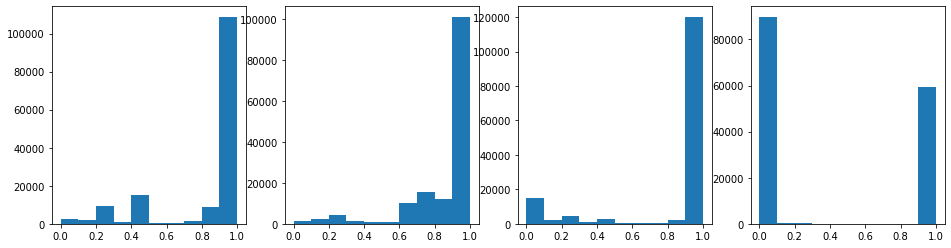

In [6]:
# list comprehension to make an array of 1D array data
data1d = [data[:,:,ch].reshape(-1) for ch in range(data.shape[2])]
# histogram values
fig,axes=plt.subplots(1,len(data1d),figsize=(16,4),facecolor='w')
for index,ch_data in enumerate(data1d):
    axes[index].hist(ch_data)
plt.show()

The last channel (right-most plot) is almost entirely 1.0 and 0.0. That channel shows the blackness, so it's basically all background pixels vs. foreground (Hormer's) pixels. But it seems there are some pixels in between those values? Zoom in:

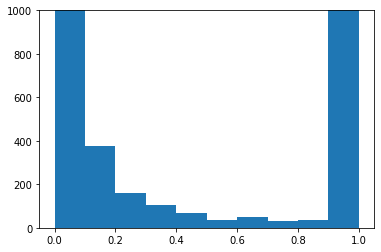

In [7]:
plt.hist(data1d[-1])
plt.ylim(0,1000)
plt.show()

Indeed there're some. Where are they? We would guess those must be the "boundary" pixels where the background transition into the foreground pixel values. Let's fine _where_ they are. 

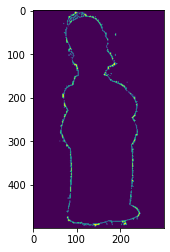

In [8]:
where = ((data[:,:,-1] > 0.) & (data[:,:,-1] < 1.)).astype(np.int32)
plt.imshow(where)

Woohoo! As expected we got the "edge" pixels. In the above, the variable `where` is a dense numpy array.

<a href="scipy"></a>
## Fitting with Scipy

<img src="logos/scipy.png" style="width: 250px;">

`scipy` is built on top of `numpy` for statistical data analysis. Let's practice fitting a function to data points using `scipy`!

We generate a toy dataset for an ionization of electrons. The amplitude of a singal is stored in a variable named `charge` as an electron count, which is 16,000 smeared by a normal distribution of a width 0.2. For each data point, we also simulate the time it takes for these electrons to drift before detection. This is a flat distribution between 0.0 to 3.0ms. During the drift, electrons might be lost due to positively charged atoms on the way. We model this process by an exponential decay _lifetime_ of 3.0ms, applied as a reduction factor to the number o electrons.


In [9]:
drift_time=np.random.random(10000)*3.
charge=abs(np.random.randn(10000)*0.2+1.0)*1.6e3 * np.exp(-1 * drift_time / 3.)

Let's first plot the data points

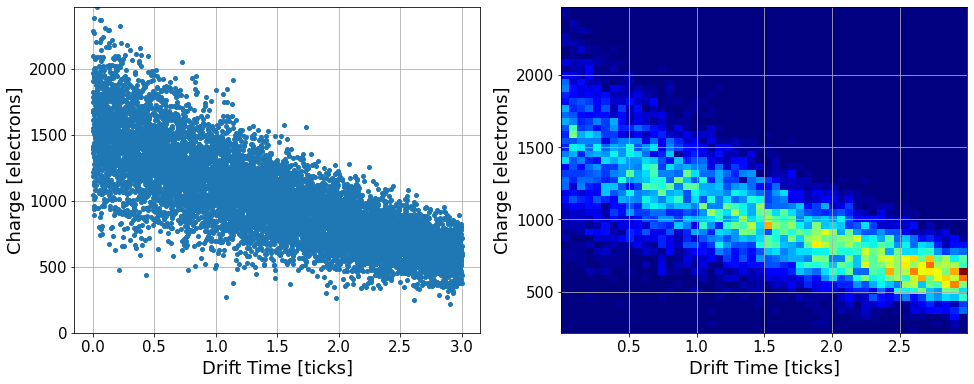

In [10]:
import matplotlib.pyplot as plt

# scatter plots
fig,axes=plt.subplots(1,2,figsize=(16,6),facecolor='w')
axes[0].plot(drift_time, charge, marker='o', markersize=4, linestyle='')
axes[0].set_ylim(0,charge.max())
axes[0].grid(True)

# 2D histogram
#fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
axes[1].hist2d(drift_time, charge, bins=(50,50), cmap='jet')
axes[1].grid(True)

for ax in axes:
    ax.set_xlabel('Drift Time [ticks]',fontsize=18)
    ax.set_ylabel('Charge [electrons]',fontsize=18)
    ax.tick_params(labelsize=15)

plt.show()

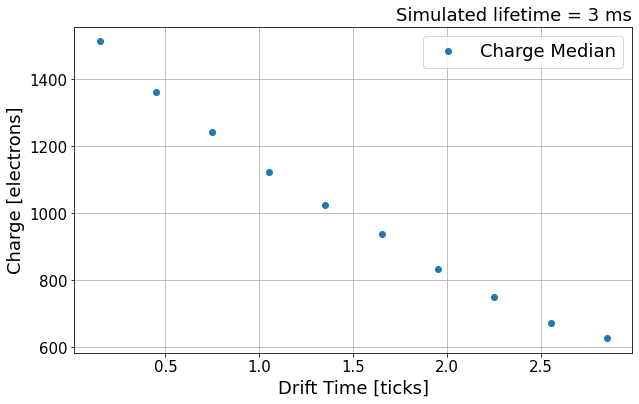

In [11]:
# Subdivide the data into 10 equal size bins across 0-3.0ms, compute the median
num_bins = 10
bin_center=np.zeros(shape=(10),dtype=np.float32)
charge_median=np.zeros(shape=(10),dtype=np.float32)
for idx in range(num_bins):
    time_min = drift_time.min() + (drift_time.max() - drift_time.min()) / num_bins * idx
    time_max = drift_time.min() + (drift_time.max() - drift_time.min()) / num_bins * (idx+1)
    mask = (time_min <= drift_time) & (drift_time < time_max)
    bin_center[idx]=time_min + (time_max - time_min)/2.
    charge_median[idx]=np.median(charge[mask])

# EXERCISE: in above, we did grouping of data points by hand.
#           You can do a similar thing with np.histogram and/or 
#           plt.hist functions that visualize *and* return binnin + population
#           Try yourself!


# Visualize
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))

ax.errorbar(x=bin_center, y=charge_median, marker='o', linestyle='', label='Charge Median')

ax.legend(fontsize=18, loc='best')
ax.set_xlabel('Drift Time [ticks]',fontsize=18)
ax.set_ylabel('Charge [electrons]',fontsize=18)
ax.set_title('Simulated lifetime = 3 ms', loc='right', fontsize=18)
ax.tick_params(labelsize=15)
ax.grid(True)

plt.show()

Next, we try to fit a function to these median points using `scipy.optimize.curve_fit` function.

In [12]:
from scipy.optimize import curve_fit

def exp(x, a0, tau):
    '''
    This defines the exponential function 
    that depends on a0 and tau
    '''
    return a0 * np.exp(-x/tau) 

def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    '''
    Call this to fit a function func on data x,y
    You can pass the initial seeds, and the range 
    to use for the fit.
    '''
    if fit_range is not None:
        sel = (fit_range[0] <= x) & (x < fit_range[1])
        x, y = x[sel], y[sel]
        
    vals, cov = curve_fit(func, x, y, seed, **kwargs)
    
    fitf = lambda x: func(x, *vals)
    
    errors = np.sqrt(np.diag(cov))
    
    return fitf, vals, errors

Let's fit now! `seed` are the parameters of the fit target, which are `a0` and `tau` of `exp` function above (i.e. all arguments after the first is considered a list of parameters).

In [13]:
seed = 1000., 1.
fitf, vals, errs = fit(func=exp, 
                       x=bin_center, 
                       y=charge_median, 
                       seed=seed, 
                       fit_range=(0.0, 3.0))
print('Fit results:', vals)

Fit results: [1588.53925643    3.03459729]


Visualize the fit results with data points!

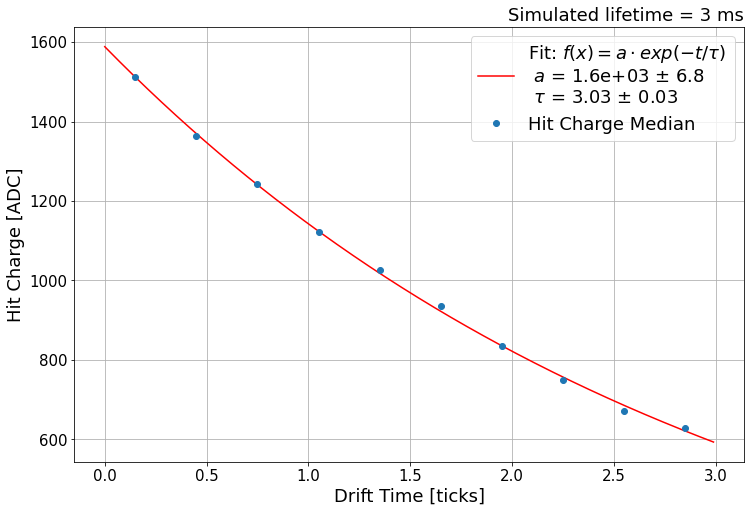

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))

ax.errorbar(x=bin_center, y=charge_median, marker='o', linestyle='', label='Hit Charge Median')

x = np.arange(0, 3.,0.01)

legend = f'Fit: $f(x) = a\cdot exp(-t/\\tau)$ \n $a$ = {vals[0]:.2} $\pm$ {errs[0]:.2} \n $\\tau$ = {vals[1]:.3} $\pm$ {errs[1]:.1}'

plt.plot(x, fitf(x), 'r-', label=legend)

ax.legend(fontsize=18, loc='best')
ax.set_xlabel('Drift Time [ticks]',fontsize=18)
ax.set_ylabel('Hit Charge [ADC]',fontsize=18)
ax.set_title('Simulated lifetime = 3 ms', loc='right', fontsize=18)
ax.tick_params(labelsize=15)
ax.grid(True)

plt.show()

<a href="plotly"></a>
## Plotly 

`matplotlib` is great for addressing most of the plotting needs, yet we should not it's a _static_ visualization. You can think of it as "it's creating an image file" each time you are plotting. So once it's plotted, it is static, doesn't move, and _cannot be interactive_! 

An interactive visualization (zoom in, out, rotate, shift, etc.) can be quite helpful to understand data. For visualizing 3D image (or anything beyond 2D in general), the whole fetures cannot be seen on our 2D computer screen (OK, VR covers 3D, how about 4D? :)

`plotly` is one of popular solution for science applications. Below, we try an example of plotting 3D points and create an interactive event display.

<img src="logos/plotly.png" style="width: 250px;">

In [15]:
import plotly.graph_objs as go

# load data points
tracks=np.load('data/tracks.npz')

# Create "traces" = instances that can be plotted. 
# In our case, a trace is created per particle trajectory
traces=[]
for name,pts in tracks.items():
    traces.append(go.Scatter3d(x=pts[:,0],y=pts[:,1],z=pts[:,2],name=name,
                               mode='markers',
                               marker=dict(size=1.5,color=pts[:,4],colorscale='Inferno'),
                               hovertext=['Energy %.2f MeV' % energy for energy in pts[:,4]]
                              )
                 )
# Now plot!
fig = go.Figure(data=traces)
fig.update_layout(legend=dict(x=1.1, y=0.9), height=768, width=768)
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/tracks.npz'


<a href="hdf5"></a>
## HDF5 for saving numpy array
<img src="logos/hdf5.png" style="width: 120px;">

We would like to be able to "save" our data after some analysis, such as your awesomer Homer image. Here I introduce two options: numpy and HDF5 files. Let us generate a bit bigger data, 128 samples of Homer.png equivalent size data. Why 128? Nothing special about the number, but I made it large enough to see some use in compression options when saving in a file.

In [16]:
import os
os.system('curl -O https://web.stanford.edu/~kterao/Homer.png')
data=plt.imread('Homer.png')

batch_data  = np.array([data for _ in range(128)])
batch_index = np.array(range(128))
print('data size:',batch_data.size*4/1.e6,'[MB]')

data size: 307.2 [MB]


### Numpy and HDF5 files
We use [numpy.savez](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html#numpy.savez) and [h5py.create_dataset](http://docs.h5py.org/en/stable/high/dataset.html) to store multiple numpy arrays (`batch_data` and `batch_index`). Before we get into details, the bottom line is that I recommend HDF5 over simple numpy files in most usecases. Further, I personally recommend [pytable](https://www.pytables.org/) for organizing your data and storing/reading in/from HDF5 format. OK, sorry, enough advertisement here.

Below, we execute code to store numpy arrays in 4 methods: numpy w/ and w/o compression as well as HDF5 w/ and w/o compression using `h5py`. We report time it takes and output filesize.

In [17]:
import time
# Numpy file w/o compression
t0=time.time()
np.savez('example.npz',data=batch_data,index=batch_index)
print('Numpy w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('example.npz')/1.e6,'MB')
# Numpy file w/ compression
t0=time.time()
np.savez_compressed('example_compressed.npz',data=batch_data,index=batch_index)
print('Numpy w/  comp.:',time.time()-t0,'[s] ... size',os.path.getsize('example_compressed.npz')/1.e6,'MB')
# H5 file w/o compression
import h5py as h5
f=h5.File('example.h5','w')
t0=time.time()
f.create_dataset('data',data=batch_data)
f.create_dataset('index',data=batch_index)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('example.h5')/1.e6,'MB')
# H5 file w/ compression
f=h5.File('example_compressed.h5','w')
t0=time.time()
f.create_dataset('data',data=batch_data, chunks=True, compression='gzip')
f.create_dataset('index',data=batch_index, chunks=batch_index.shape, compression='gzip')
f.close()
print('HDF5  w/  comp.:',time.time()-t0,'[s] ... size',os.path.getsize('example_compressed.h5')/1.e6,'MB')

Numpy w/o comp.: 0.7814552783966064 [s] ... size 307.201528 MB
Numpy w/  comp.: 4.456810712814331 [s] ... size 20.957949 MB
HDF5  w/o comp.: 0.41431450843811035 [s] ... size 307.203072 MB
HDF5  w/  comp.: 2.845186233520508 [s] ... size 7.254736 MB


It's good to observe something we expect: the file size should be roughly the data size (307 MB) without any compression. We can see HDF5 is about twice faster than numpy file option either with or without compression option. The compressed HDF5 file is about 3 times smaller than numpy compressed file, which is great. This comes at a cost of running a compression algorithm, hence longer time to finish writing. Note that data compression has some parameters to consider, such as algorithm itself (here we used `gzip`) and chunk size, which you can consider as a block size for IO operation optimization. We come back to this later.

Now, often you perform more _read_ operation than _write_ operation to a file (i.e. you may write a file once, and you typically read the same file many times). So read performance is often more important than the write performance. Let's see how long it takes to "read" data from a file. First, we try just fetching the data shape information from the stored files.

In [18]:
# Numpy file w/o compression
t0=time.time()
d=np.load('example.npz')
print('Numpy w/o comp.: data shape =',d['data'].shape,time.time()-t0,'[s]')
# Numpy file w/  compression
t0=time.time()
d=np.load('example_compressed.npz')
print('Numpy w/  comp.: data shape =',d['data'].shape,time.time()-t0,'[s]')
# H5 file w/o compression
t0=time.time()
f=h5.File('example.h5','r')
print('HDF5  w/o comp.: data shape =',f['data'].shape,time.time()-t0,'[s]')
f.close()
# H5 file w/  compression
t0=time.time()
f=h5.File('example_compressed.h5','r')
print('HDF5  w/  comp.: data shape =',f['data'].shape,time.time()-t0,'[s]')
f.close()

Numpy w/o comp.: data shape = (128, 500, 300, 4) 0.7855966091156006 [s]
Numpy w/  comp.: data shape = (128, 500, 300, 4) 1.2051024436950684 [s]
HDF5  w/o comp.: data shape = (128, 500, 300, 4) 0.020783185958862305 [s]
HDF5  w/  comp.: data shape = (128, 500, 300, 4) 0.001802206039428711 [s]


First, we see read-speed difference between numpy files w/ vs. w/o compression. This is expected, like we saw while writing these files, because a compressed file needs to run an algorithm to expand the compressed infomration.

Second, we see that HDF5 files are **much faster** than numpy files. This is because HDF5 files store "data header information" separately from the data itself while numpy files don't. The data shape information is actually in the header, much smaller than the whole data, and that is fetched for HDF5 files. Accordingly the difference in compressed or not does not apply here for HDF5 files. On the other hand, for numpy files, the whole data is read-in, hence slow + we see difference between w/ vs. w/o compression.

Next, we force HDF5 file data to be read by computing the sum of matrix in the first entry.

In [19]:
# Numpy file w/o compression
t0=time.time()
d=np.load('example.npz')
print('Numpy w/o comp.: first entry sum =',d['data'][0].sum(),time.time()-t0,'[s]')
# Numpy file w/  compression
t0=time.time()
d=np.load('example_compressed.npz')
print('Numpy w/  comp.: first entry sum =',d['data'][0].sum(),time.time()-t0,'[s]')
# H5 file w/o compression
t0=time.time()
f=h5.File('example.h5','r')
print('HDF5  w/o comp.: first entry sum =',f['data'][0].sum(),time.time()-t0,'[s]')
f.close()
# H5 file w/  compression
t0=time.time()
f=h5.File('example_compressed.h5','r')
print('HDF5  w/  comp.: first entry sum =',f['data'][0].sum(),time.time()-t0,'[s]')
f.close()

Numpy w/o comp.: first entry sum = 445387.84 0.6368029117584229 [s]
Numpy w/  comp.: first entry sum = 445387.84 1.2581286430358887 [s]
HDF5  w/o comp.: first entry sum = 445387.84 0.006718158721923828 [s]
HDF5  w/  comp.: first entry sum = 445387.84 0.12124133110046387 [s]


You can see the time took for operating on numpy files did not change much. This is because the time spent is dominated by file-read operation. For HDF5 files, now we see clear difference between w/ vs. w/o compression, almost by a factor of 30! Nevertheless, the read speed is much faster than numpy files.

## _Smart_ Compression
Could we improve read-speed for the compressed HDF5 file? The answer is yes, and there are a few ways to pursue. One important thing to consider is what's called a _chunk size_. For image data, we are almost always certain that the smallest unit of file-read operation is one image. We usually don't read 0.3 or 0.5 image. So it is reasonable to set the base unitsize of file read (i.e. chunk size) to be the dimension of an image. Let's re-make the compressed file with this assumption for `batch_data`. For `batch_index`, because it's so small (only 128 integers), we set the chunk size to be the whole data as file-read should be fast.

In [ ]:
# H5 file w/ compression
f=h5.File('example_smart_compressed.h5','w')
t0=time.time()
f.create_dataset('data',data=batch_data, chunks=tuple([1]+list(data.shape)), compression='gzip')
f.create_dataset('index',data=batch_index, chunks=batch_index.shape, compression='gzip')
f.close()
print('HDF5  w/  comp.:',time.time()-t0,'[s] ... size',os.path.getsize('example_smart_compressed.h5')/1.e6,'MB')

Now we see the compression factor (i.e. file size) is not as great as before. In fact, it is about same as numpy counterpart, although the file-write speed is still fast. Let's try reading the firsty entry in data and compute the matrix sum.

In [21]:
# H5 file w/  compression
t0=time.time()
f=h5.File('example_smart_compressed.h5','r')
print('HDF5  w/  comp.: first entry sum =',f['data'][0].sum(),time.time()-t0,'[s]')
f.close()

HDF5  w/  comp.: first entry sum = 445387.84 0.016582012176513672 [s]


While this is still slower than uncompressed file, it has improved by several factors. Remember to choose a reasonable chunksize for your data! It can change your data-read speed by several factors. If you plan to do a neural network training with a batch that consists of random selection of images, having a fast, image-by-image random access is very important.

... so what about an array of variable-length data? That's outside of this 5-minutes notebook :) But HDF5 supports this and you only need to learn a bit more beyond 5 minutes!